In [12]:
import pandas as pd
import numpy as np
import hdbscan
import sklearn
import umap
import scipy    
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
matfile=scipy.io.loadmat('PSTH.mat')
data=matfile['allPSTH']
data.shape

(371, 200)

In [21]:
np.save("allPSTH.npy",data)

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

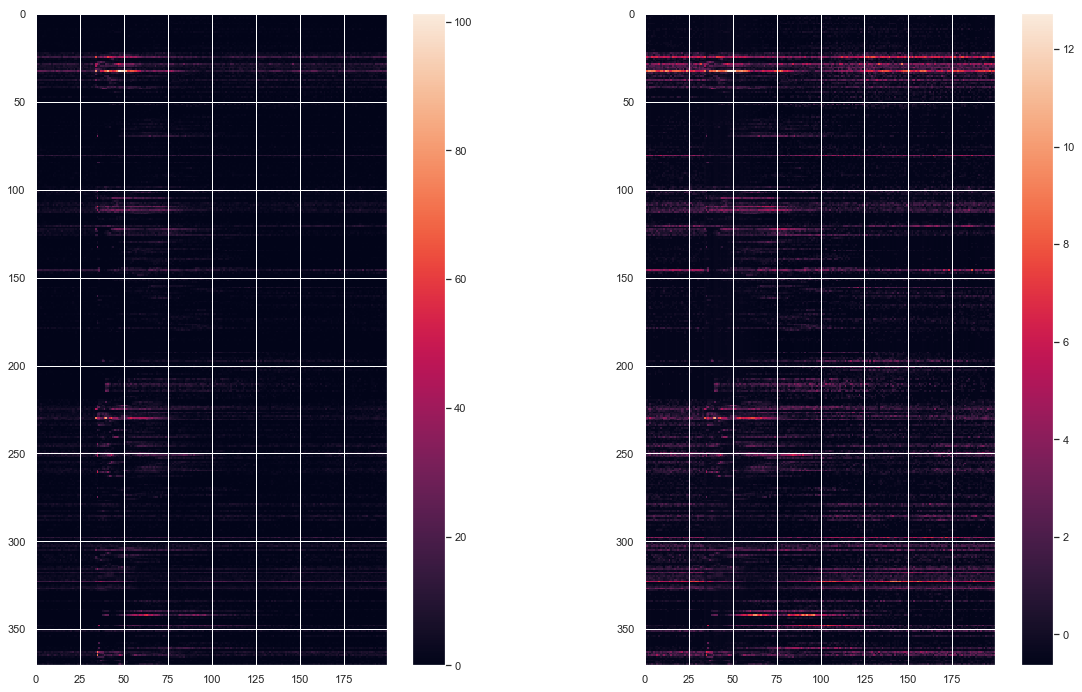

In [107]:
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(data);
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(data_std);

plt.colorbar()
plt.show()

In [439]:
timeBaseline = 33
meanBaseline = np.mean(data[:,:timeBaseline],axis=1)
stdBaseline = np.std(data[:,:timeBaseline],axis=1)
normData = ((data.transpose() - meanBaseline)/(stdBaseline)).transpose()
normData.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


(371, 200)

In [441]:
normData_clean = normData[~np.isnan(normData).any(axis=1)]#normData[np.all(normData<20, axis=1),:] #np.delete(normData, np.where(stdBaseline<0.5), 0)
normData_clean.shape

(323, 200)

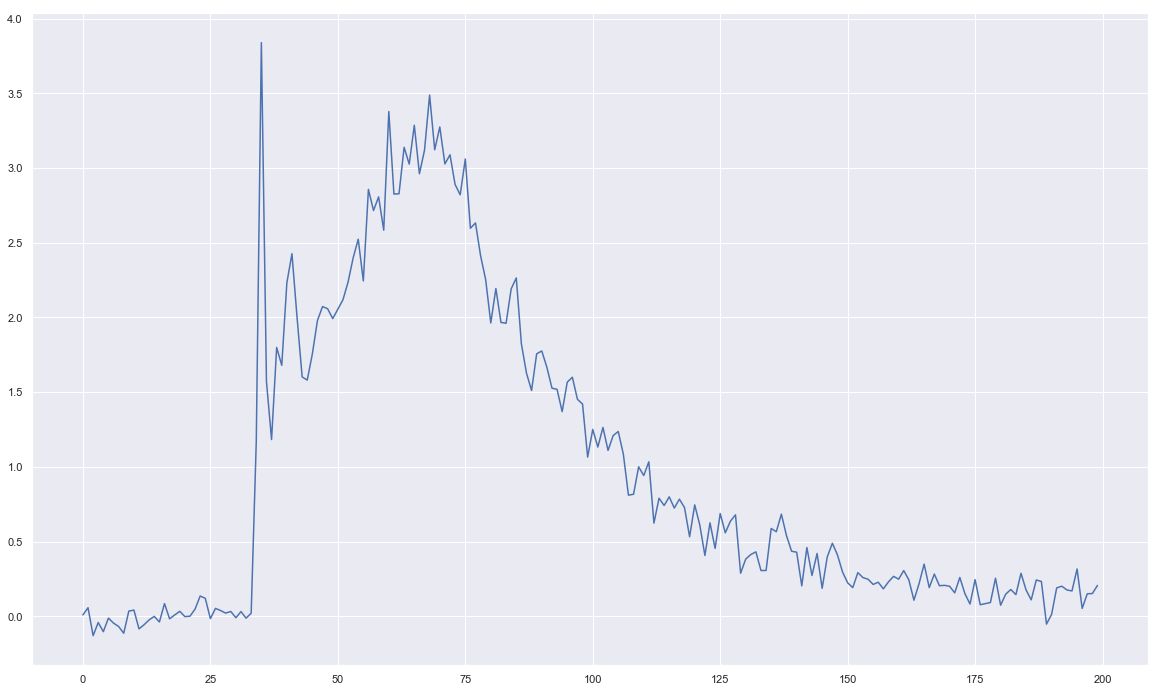

In [445]:
plt.plot(np.nanmean(normData_clean,axis=0))

In [446]:
normData_clean_std = StandardScaler().fit_transform(normData_clean)

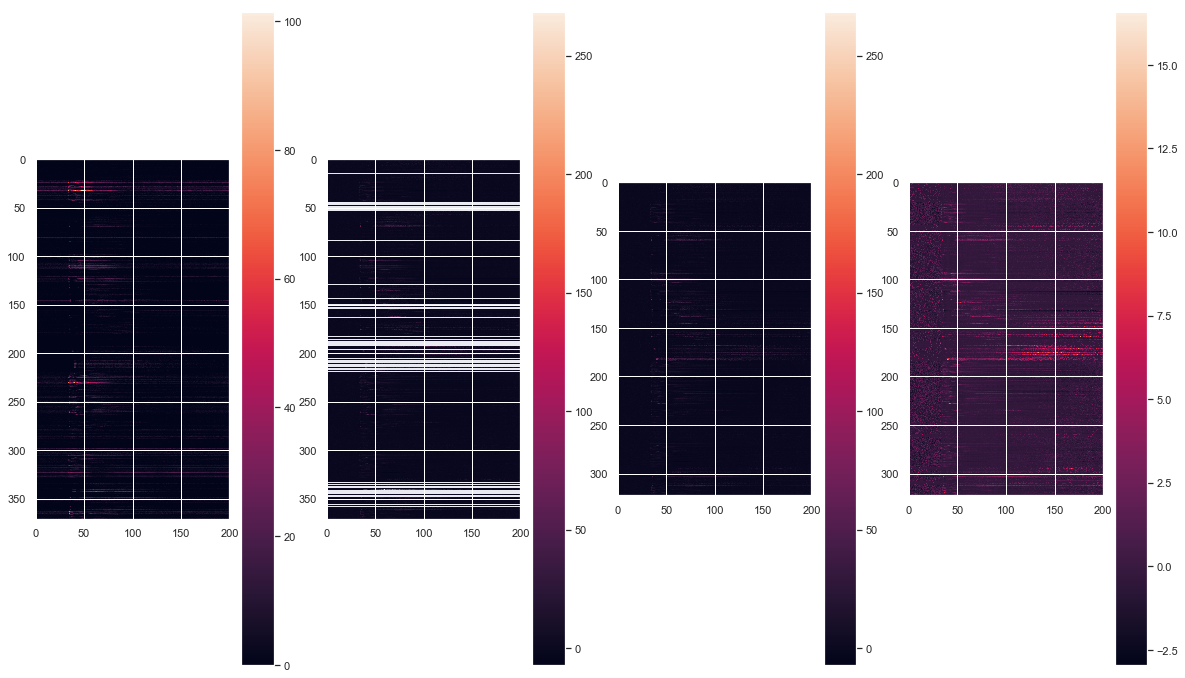

In [447]:
fig = plt.figure()

plt.subplot(1, 4, 1)
plt.imshow(data);
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(normData);
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(normData_clean);
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(normData_clean_std);
plt.colorbar()

plt.show()

Text(0, 0.5, 'PCA 2')

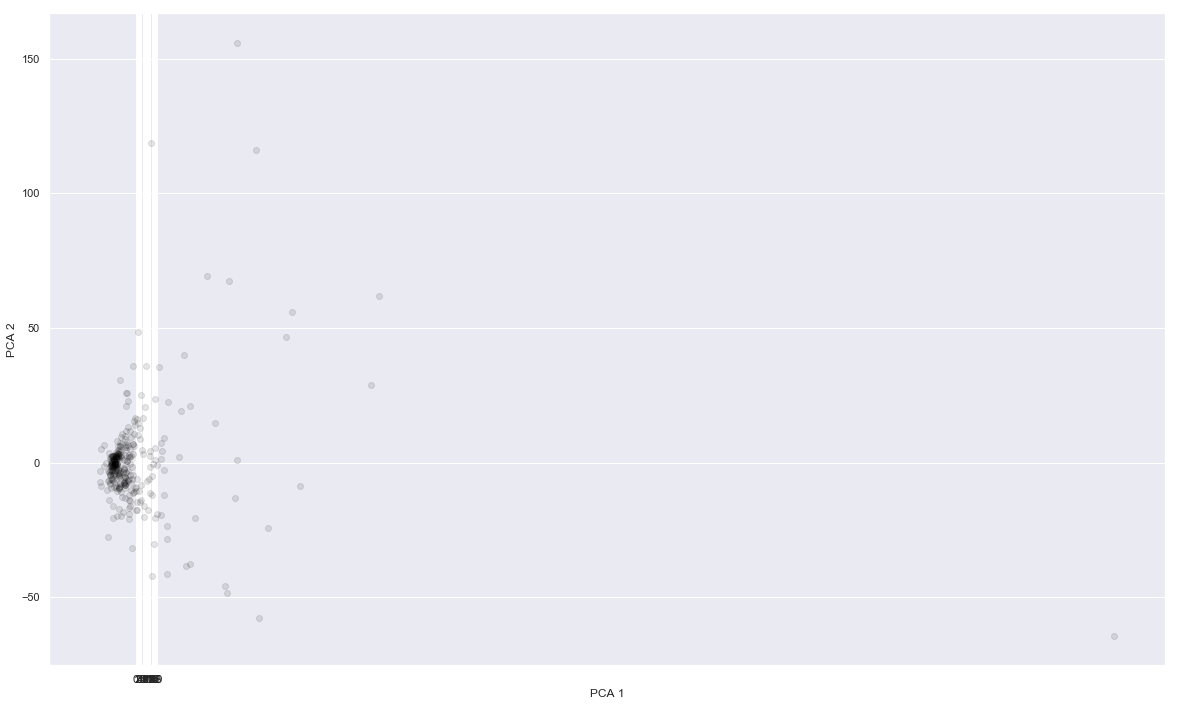

In [448]:
data_std = StandardScaler().fit_transform(data)
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(normData_clean)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

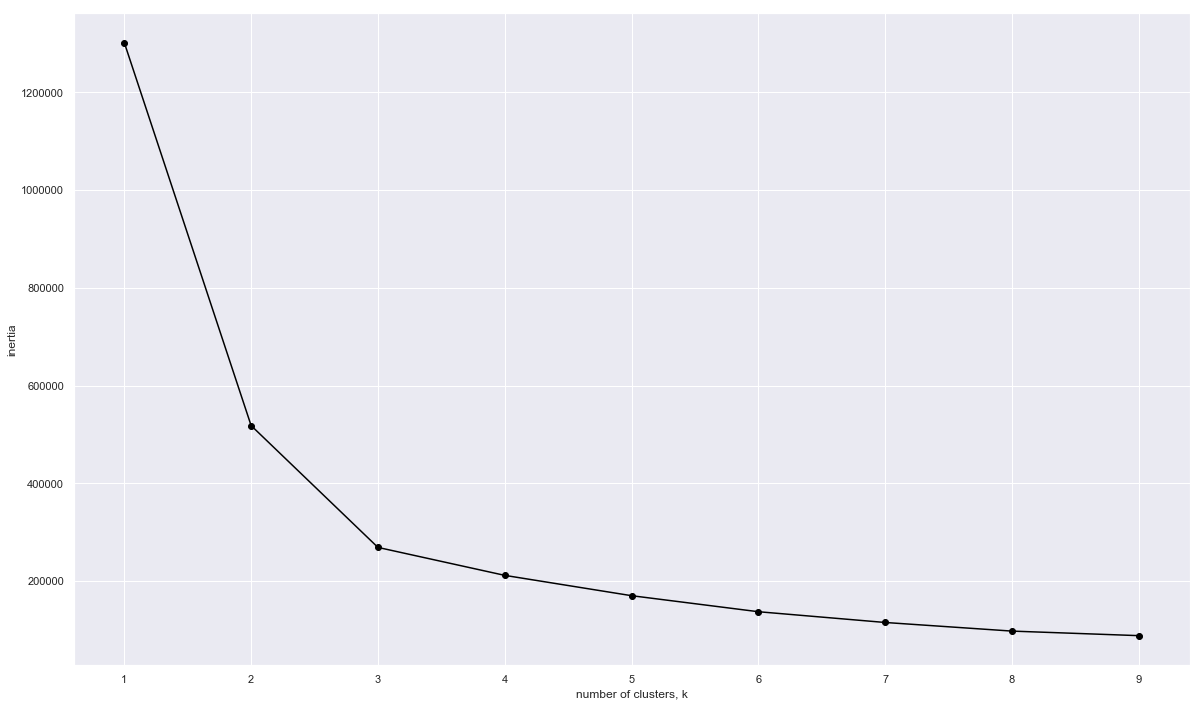

In [449]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [450]:
model = KMeans(n_clusters=3).fit(PCA_components.iloc[:,:3])
 # Fit model to samples
l = model.labels_

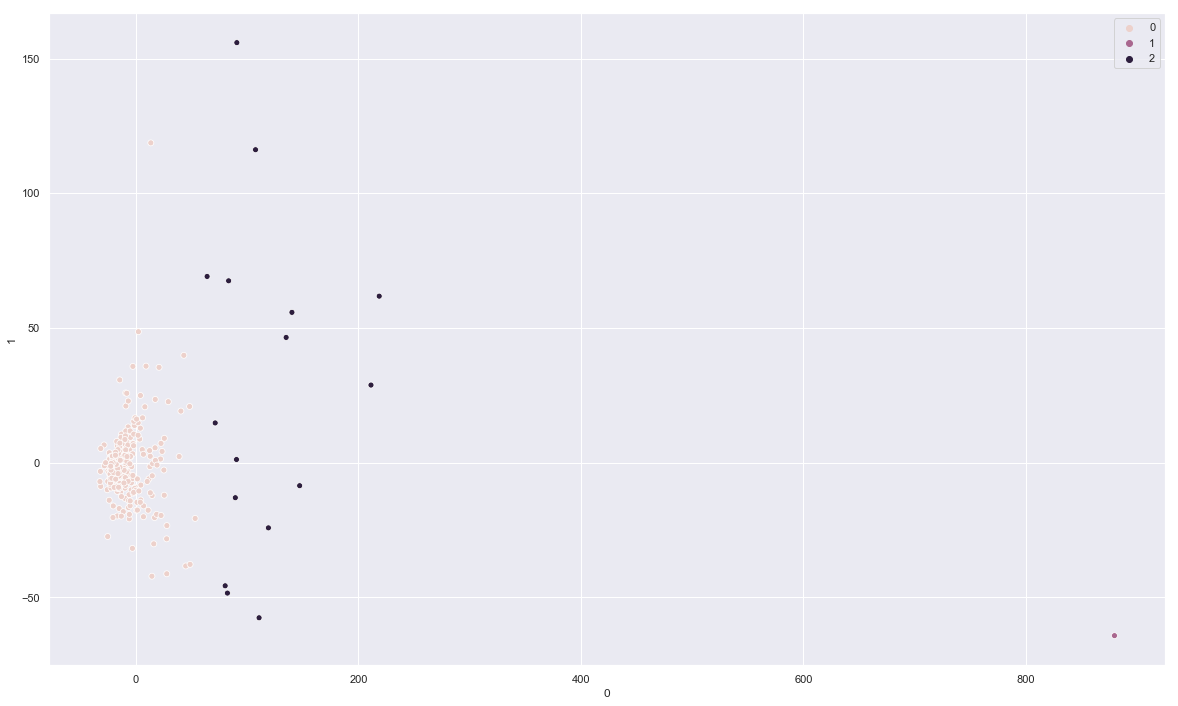

In [451]:
sns.scatterplot(PCA_components[0],PCA_components[1],hue=l)

0 306
1 1
2 16


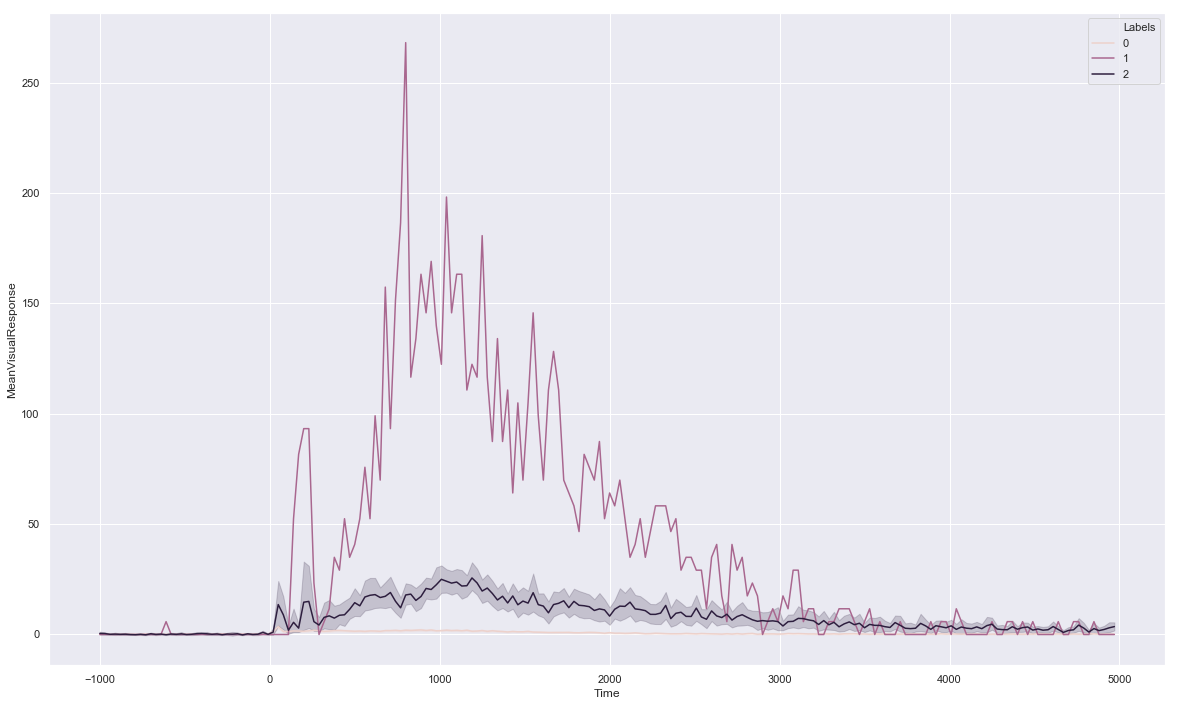

In [457]:
response = []
labels = []
time = []
for i in np.unique(l):
    #Subset data per label
    lIndeces = np.where(l==i)[0]
    print(i, len(lIndeces))
    response.extend(normData_clean[lIndeces,:].ravel().tolist())
    labels.extend([i]*200*len(lIndeces))
    time.extend(list(range(-1000,5000,30))*len(lIndeces))
#meanVectors
psthData = pd.DataFrame({"Time": time,"MeanVisualResponse": response,"Labels":labels})
psthData.head()
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(x="Time", y="MeanVisualResponse", hue="Labels", data=psthData)

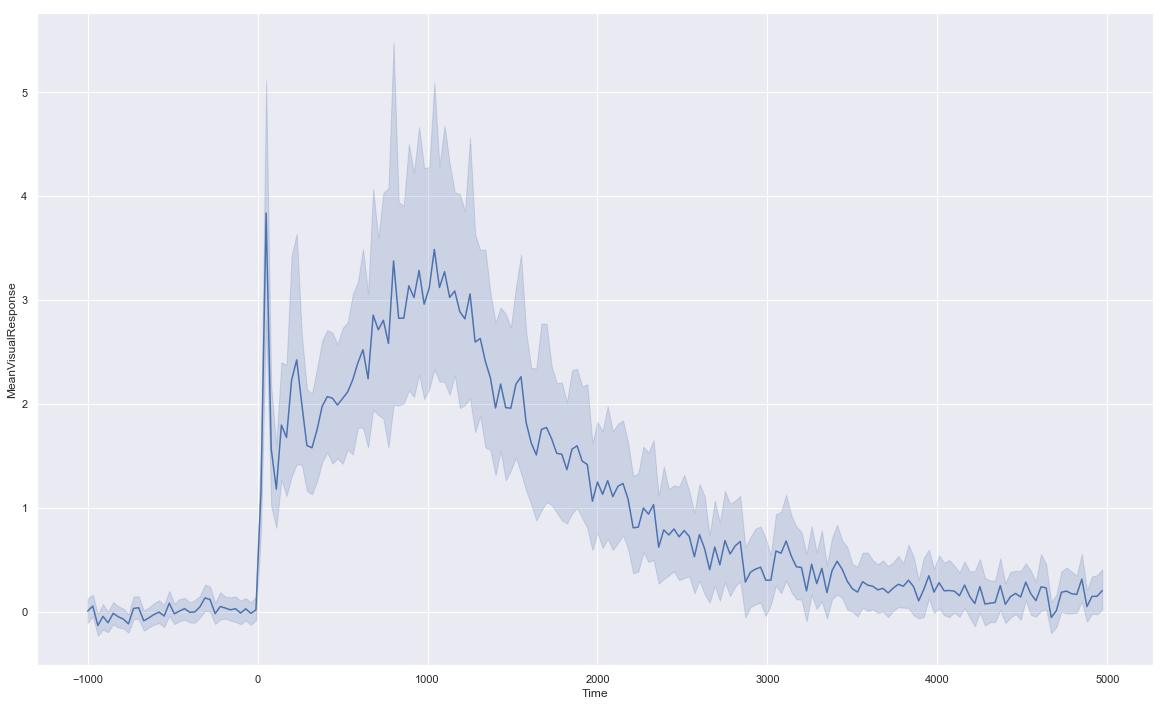

In [458]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(x="Time", y="MeanVisualResponse", data=psthData)

In [460]:
from sklearn.manifold import TSNE

In [461]:
X_embedded = TSNE(n_components=2).fit_transform(normData_clean)
X_embedded.shape

(323, 2)

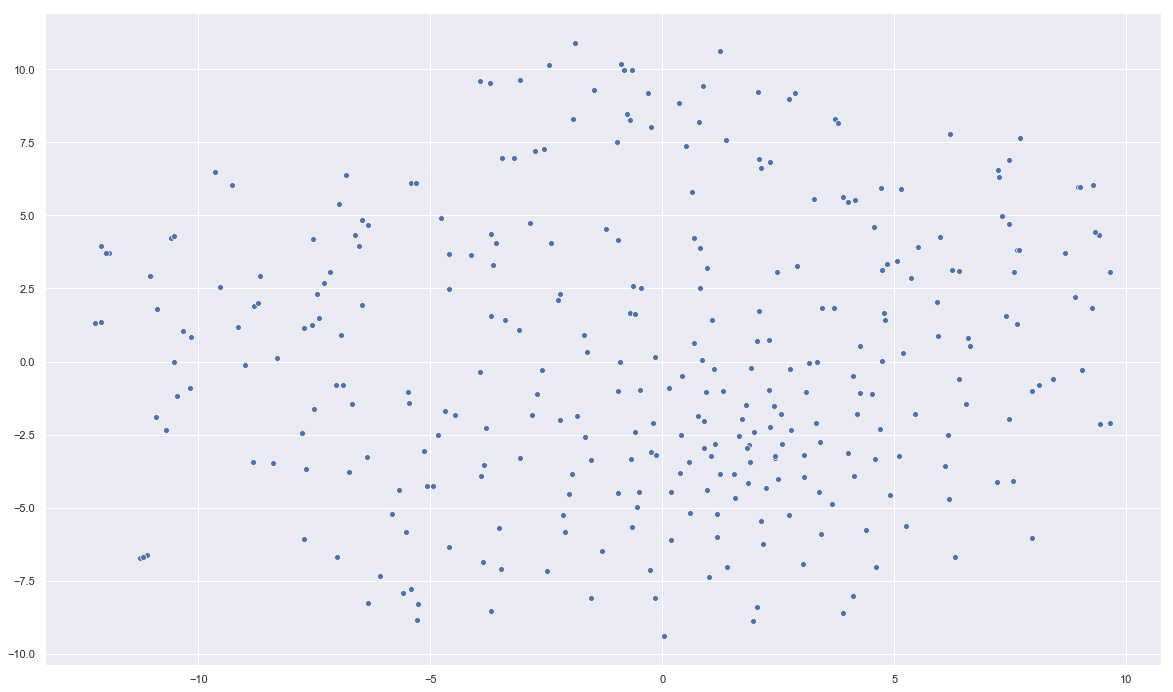

In [462]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1])

In [463]:
reducer = umap.UMAP()
data_umap = reducer.fit_transform(normData_clean)
data_umap.shape

(323, 2)

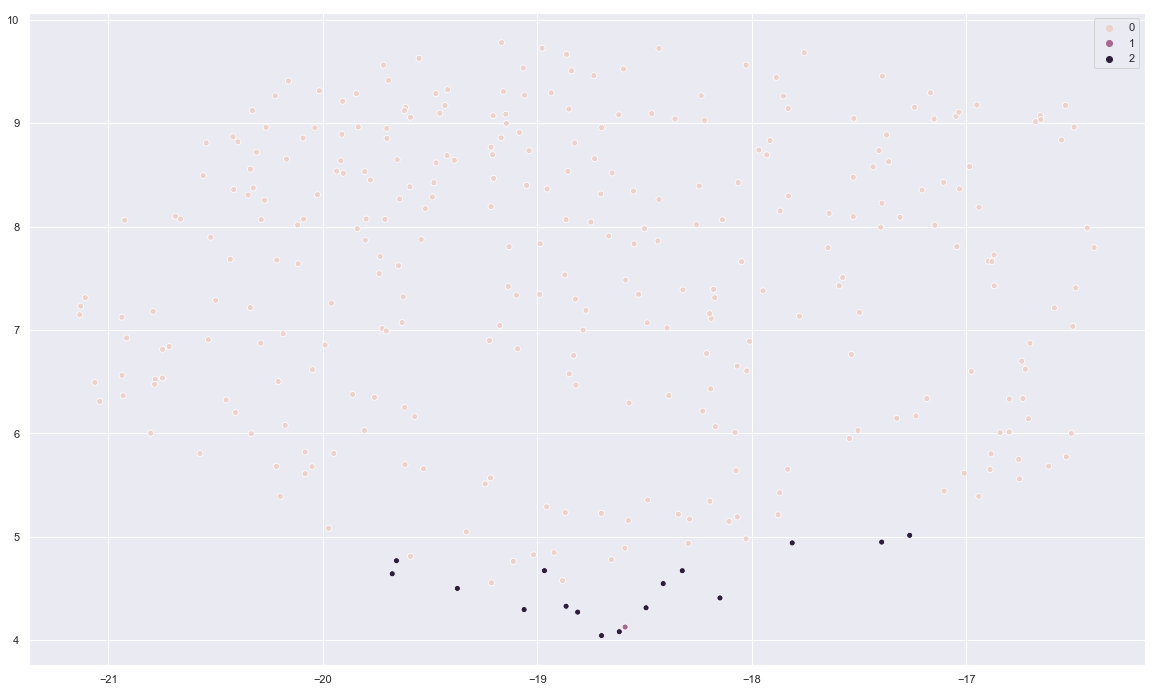

In [464]:
sns.scatterplot(data_umap[:,0], data_umap[:,1], hue=l)

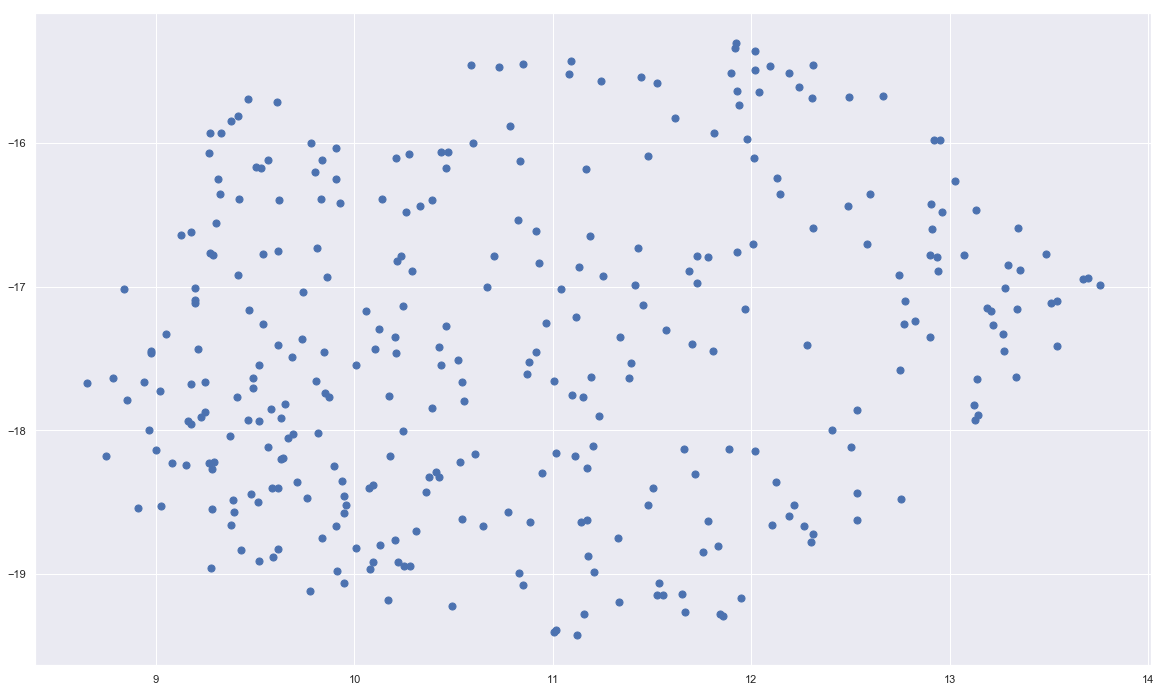

In [465]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(normData_clean)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=50, cmap='Spectral');

In [ ]:
layer = scipy.io.loadmat('layer.mat')['layer'].ravel()
age = scipy.io.loadmat('age.mat')['age'].ravel()

In [469]:
age = age[~np.isnan(normData).any(axis=1)]
layer = layer[~np.isnan(normData).any(axis=1)]

In [470]:
categories = pd.DataFrame({"Age":age.tolist(), "Layer":layer.tolist()})
categories["Combined"] = categories["Layer"].astype(str)+"_"+categories["Age"].astype(str)
categories["X"] = clusterable_embedding[:, 0]
categories["Y"] = clusterable_embedding[:, 1]
categories.head()

,Age,Layer,Combined,X,Y
0,8,3,3_8,10.249364,-18.942223
1,8,3,3_8,9.914307,-18.974728
2,8,3,3_8,9.775476,-19.118227
3,8,1,1_8,11.663967,-19.260824
4,8,1,1_8,10.075950,-18.962410


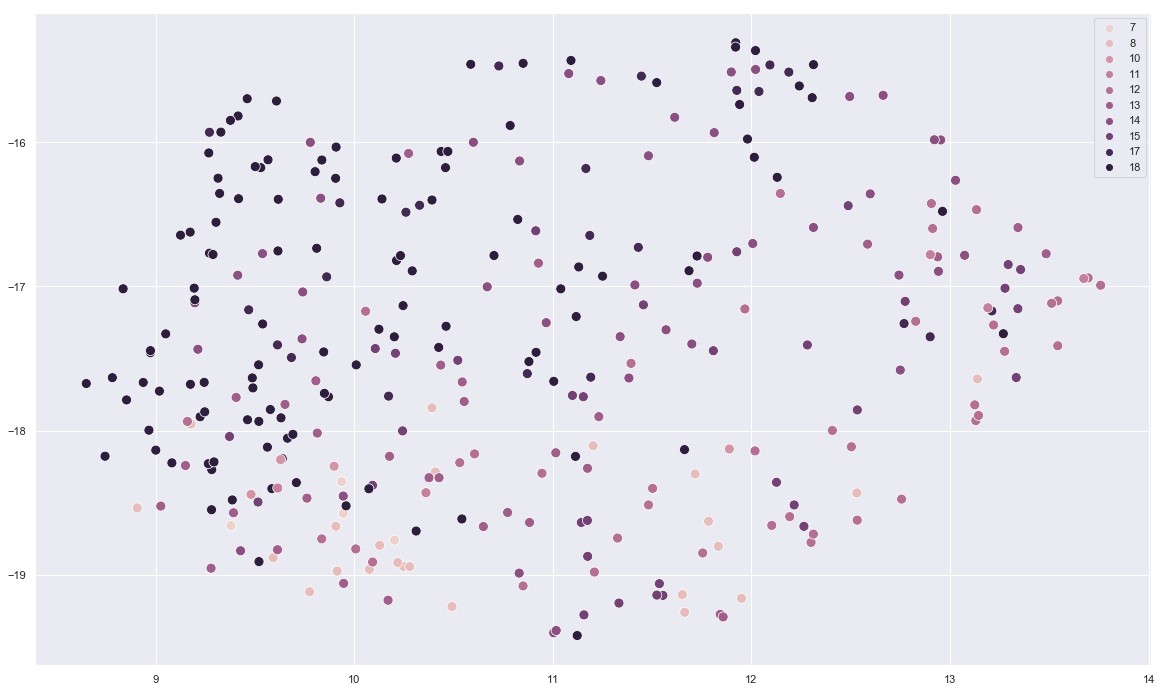

In [471]:
sns.scatterplot(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=100, hue=age, legend="full");

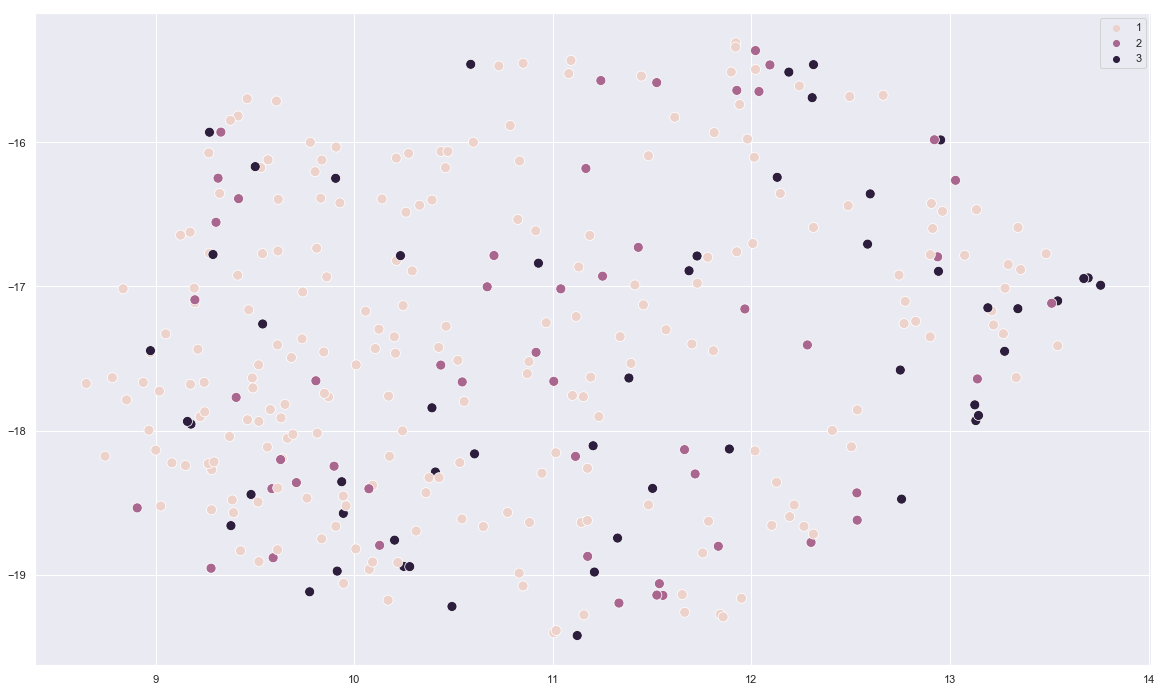

In [472]:
sns.scatterplot(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=100, hue=layer, legend="full");

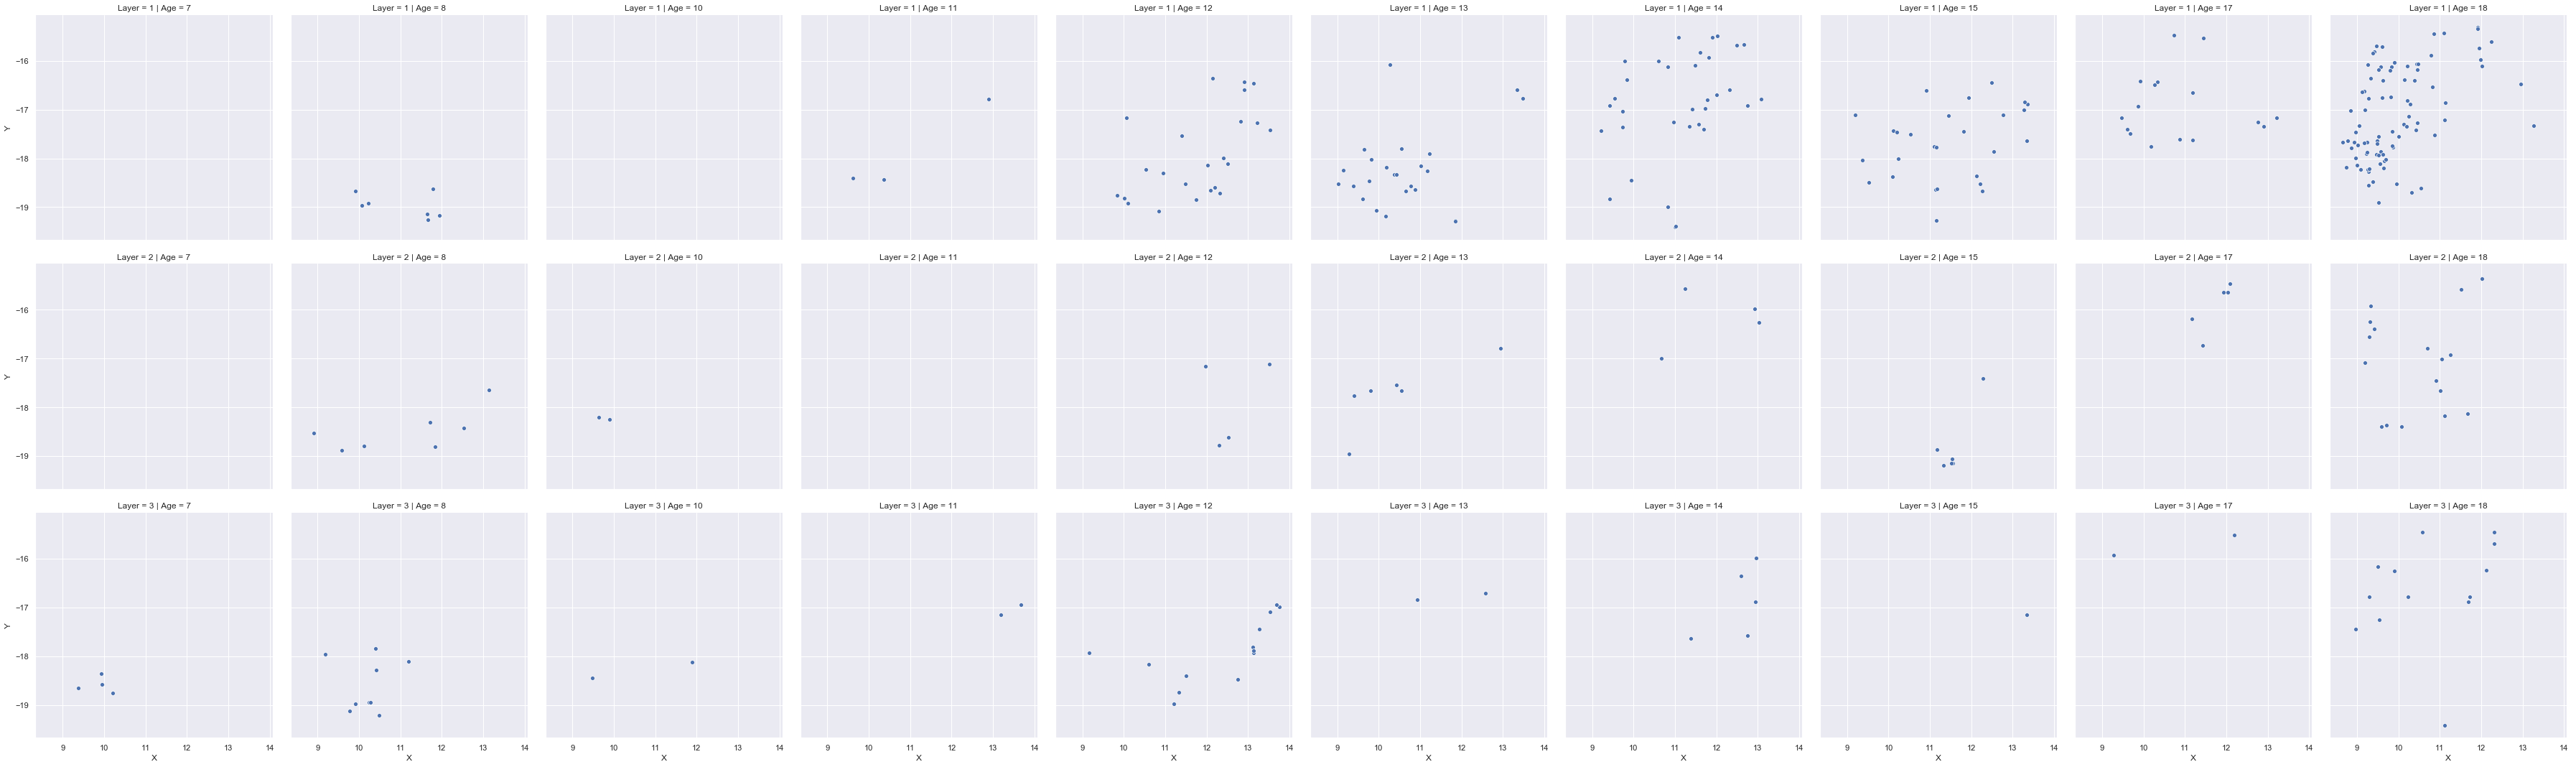

In [473]:
sns.relplot(x="X", y="Y", col="Age", row="Layer", legend="full", data=categories); 

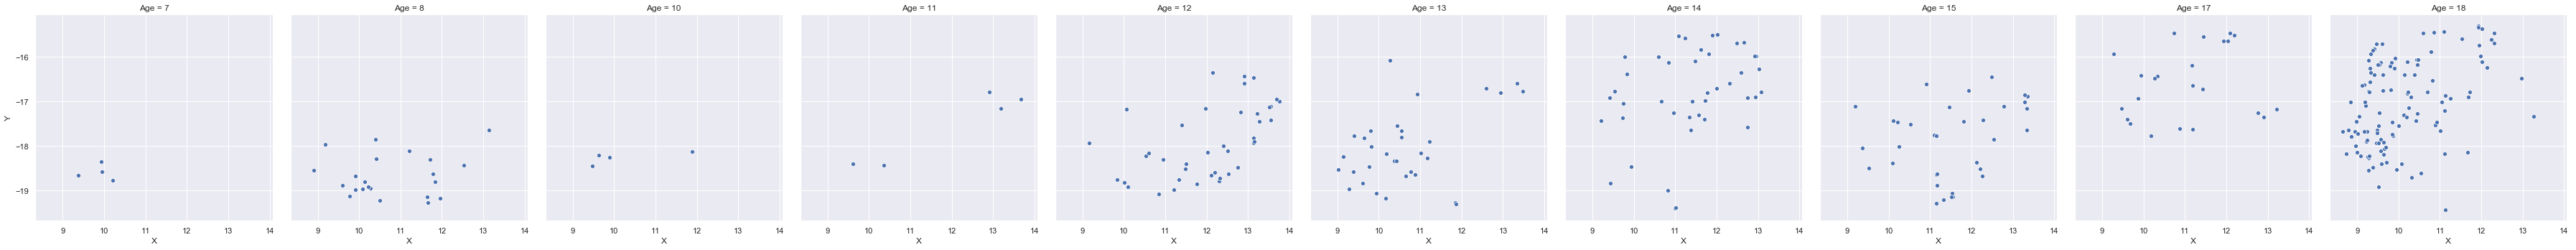

In [474]:
sns.relplot(x="X", y="Y", col="Age", legend="full", data=categories); 

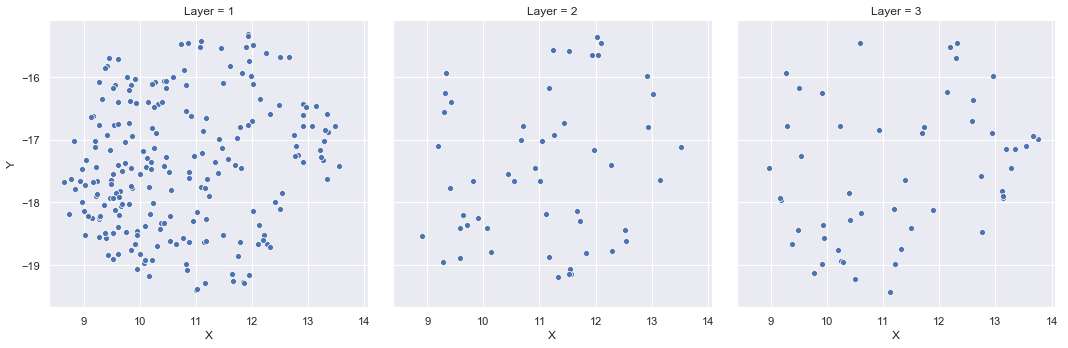

In [475]:
sns.relplot(x="X", y="Y", col="Layer", legend="full", data=categories); 

In [ ]:

    cluster_selection_method="leaf",
    allow_single_cluster=True,
    cluster_selection_epsilon=.5,
    min_cluster_size=10 

In [504]:
labels = hdbscan.HDBSCAN(cluster_selection_epsilon=.5).fit_predict(clusterable_embedding)
np.unique(labels)

array([-1,  0,  1], dtype=int64)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


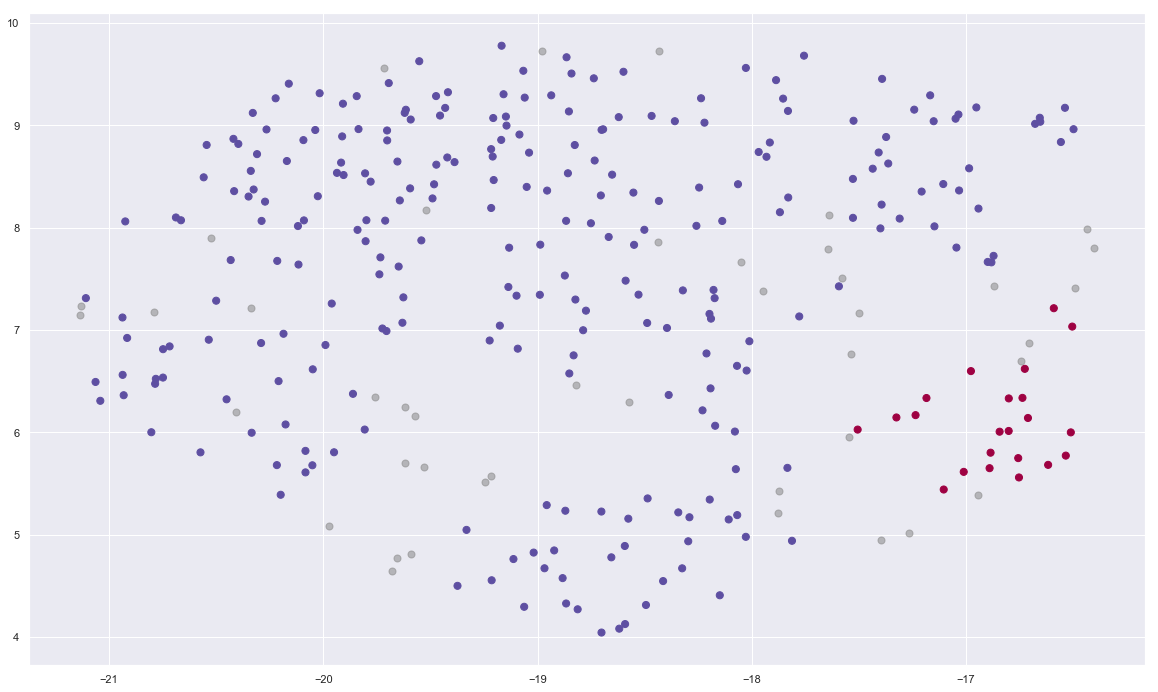

In [505]:
clustered = (labels >= 0)
plt.scatter(data_umap[~clustered, 0],
            data_umap[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=50,
            alpha=0.5)
plt.scatter(data_umap[clustered, 0],
            data_umap[clustered, 1],
            c=labels[clustered],
            s=50,
            cmap='Spectral');

In [500]:
response = []
labels_umap = []
time = []
ageRepeated = []
layerRepeated = []
for i in np.unique(labels):
    #Subset data per label
    lIndeces = np.where(labels==i)[0]
    print(i, len(lIndeces))
    response.extend(normData_clean[lIndeces,:].ravel().tolist())
    labels_umap.extend([i]*200*len(lIndeces))
    time.extend(list(range(-1000,5000,30))*len(lIndeces))
    
    ageRepeated.extend(np.repeat(age[lIndeces],200))
    layerRepeated.extend(np.repeat(layer[lIndeces],200))
#meanVectors
psthData = pd.DataFrame({"Time": time,"MeanVisualResponse": response,"Labels":labels_umap, "Age":ageRepeated, "Layer":layerRepeated})
psthData.head()

-1 28
0 21
1 38
2 236


,Time,MeanVisualResponse,Labels,Age,Layer
0,-1000,0.545250,-1,18,1
1,-970,1.363124,-1,18,1
2,-940,-1.090500,-1,18,1
3,-910,-0.272625,-1,18,1
4,-880,0.545250,-1,18,1


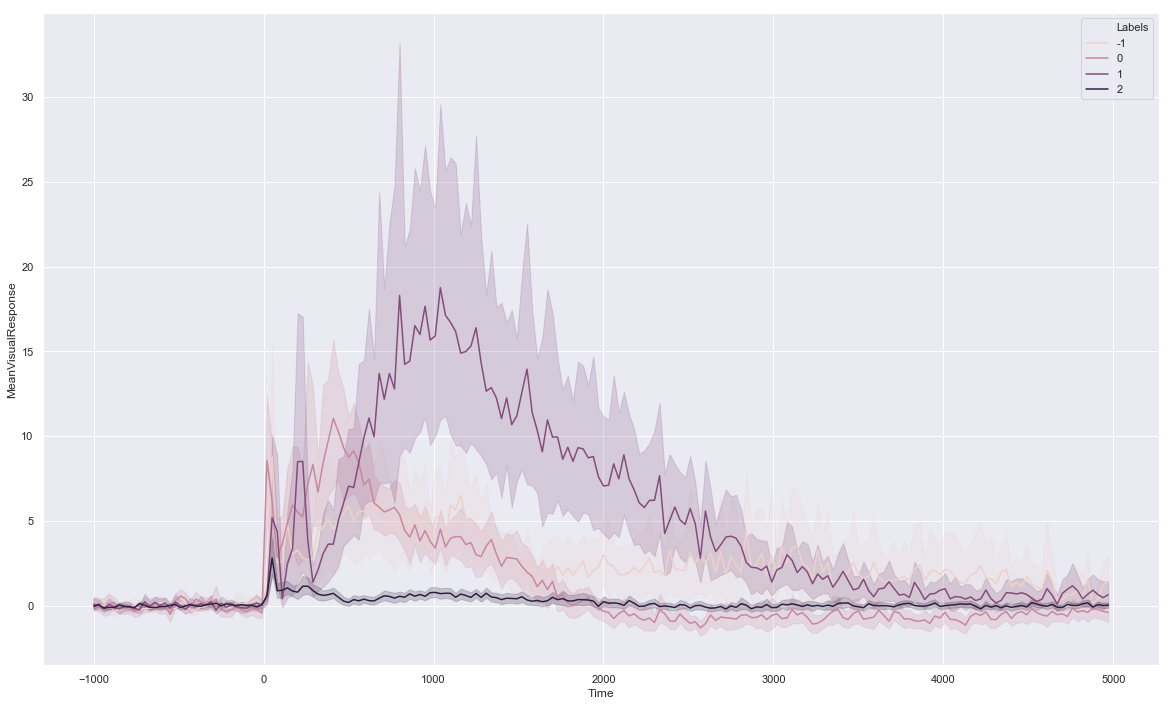

In [501]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(x="Time", y="MeanVisualResponse", hue="Labels", data=psthData, legend="full")#, palette=sns.color_palette('muted'))

In [497]:
# sns.relplot(x="Time", y="MeanVisualResponse", row="Labels", kind="line", legend="full", data=psthData)